In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

In [7]:
CSV_PATH = r"ab_test_mock_data.csv"
parse_dates = ["assigned_ts","conversion_ts"]
existing_cols = pd.read_csv(CSV_PATH, nrows=1).columns.tolist()
to_parse = [c for c in parse_dates if c in existing_cols]
df = pd.read_csv(CSV_PATH, parse_dates=to_parse)
print("shape:", df.shape)
df.head(10)

shape: (12000, 11)


,user_id,assigned_ts,variant,country,device,source,prior_activity,sessions,converted,conversion_ts,revenue
0,1936,2025-08-12 05:04:00,A,UK,mobile,organic,0.0141,1,0,NaT,13.18
1,6495,2025-08-07 09:01:00,A,US,mobile,ads,0.0832,5,0,NaT,7.27
2,1721,2025-08-03 17:24:00,B,UK,desktop,organic,0.4556,4,0,NaT,5.58
3,9121,2025-08-10 23:28:00,A,UK,mobile,organic,0.1178,4,1,2025-08-11 07:23:43.261786,18.55
4,361,2025-08-02 03:40:00,A,SE,mobile,ads,0.7019,1,0,NaT,14.30
5,9664,2025-08-05 16:19:00,A,PL,mobile,ads,0.4612,2,0,NaT,8.15
6,5278,2025-08-02 17:41:00,B,SE,desktop,organic,0.1260,3,0,NaT,17.69
7,8547,2025-08-10 01:29:00,B,UK,desktop,email,0.3166,3,0,NaT,38.84
8,2222,2025-08-11 21:41:00,B,PL,mobile,organic,0.6919,3,0,NaT,4.83
9,4618,2025-08-13 15:40:00,B,SE,desktop,ads,0.1488,1,0,NaT,15.25


In [42]:
from math import erf

def proportions_ztest(success_a, total_a, success_b, total_b):
    """Двухсторонний z-тест для разницы долей (B vs A, pooled SE)."""
    p1 = success_a/total_a
    p2 = success_b/total_b
    p_pool = (success_a + success_b) / (total_a + total_b)
    se = np.sqrt(p_pool*(1-p_pool)*(1/total_a + 1/total_b))
    z = (p2 - p1) / se
    # two-sided p-value через нормальное распределение
    def norm_cdf(x): return 0.5*(1 + erf(x/np.sqrt(2)))
    p_value = 2*(1 - norm_cdf(abs(z)))
    return z, p_value

def ci_diff_wald(success_a, total_a, success_b, total_b, alpha=0.05):
    """95% Wald CI для разницы долей (B-A). Для прод — лучше Ньюкомб/Уилсон."""
    p1 = success_a/total_a
    p2 = success_b/total_b
    se = np.sqrt(p1*(1-p1)/total_a + p2*(1-p2)/total_b)
    z = stats.norm.ppf(1 - alpha/2)
    diff = p2 - p1
    return diff, (diff - z*se, diff + z*se)

def cuped(y, x):
    """CUPED: снижение дисперсии с помощью предиктора x (предэксп. ковариат)."""
    x = x - x.mean()
    theta = np.cov(y, x, ddof=0)[0,1] / np.var(x, ddof=0)
    y_adj = y - theta * x
    return y_adj, theta


In [16]:
# 4.1 Сплит A/B
split = df.variant.value_counts().to_frame('n').reset_index()
split['share %'] = ((split['n'] / sum(split['n'])) * 100).round(3)
display(split)

,variant,n,share %
0,A,6029,50.242
1,B,5971,49.758


In [20]:
# 4.2 Утечки: пользователь в обоих вариантах
n_multi = (df.groupby('user_id')['variant'].nunique() > 1).sum()
print(n_multi)

0


In [21]:
# 4.3 Дубликаты по user_id (если есть — нужно правило дедупликации)
dup_rows = df.duplicated(['user_id'], keep = False).sum()
dup_rows

0

In [24]:
# 4.4 Временной баланс (распределение назначений по дням + KS-тест по времени)
day_tab = pd.pivot_table(
    df,
    index = df['assigned_ts'].dt.date,
    columns = 'variant',
    values = 'user_id',
    aggfunc='count'
).fillna(0).astype('int')
display(day_tab.head(10))

variant,A,B
assigned_ts,,
2025-08-01,438,420
2025-08-02,464,442
2025-08-03,461,443
2025-08-04,432,437
2025-08-05,416,418
2025-08-06,442,408
2025-08-07,433,418
2025-08-08,419,425
2025-08-09,449,408


In [30]:
a_ts = (df[df.variant=='A']['assigned_ts'].astype('int64') // 10**9)
b_ts = (df[df.variant=='B']['assigned_ts'].astype('int64') // 10**9)
ks, ks_p = stats.ks_2samp(a_ts, b_ts)
print(f'KS test on assigned_ts: KS={ks:.3f}, p={ks_p:.4f}')

KS test on assigned_ts: KS=0.021, p=0.1256


In [34]:
# 4.5 Баланс ковариат (категорические: chi-square; числовые: Welch t-test)
for col in ['country','device','source']:
    if col in df.columns:
        tab = pd.crosstab(df[col], df['variant'])
        chi2, pval, dof, _ = stats.chi2_contingency(tab, correction=False)
        print(f'[chi2] {col}: p={pval:.4f} (dof={dof})')

[chi2] country: p=0.5934 (dof=4)
[chi2] device: p=0.0617 (dof=1)
[chi2] source: p=0.7715 (dof=3)


In [33]:
for col in ['prior_activity','sessions']:
    if col in df.columns:
        a = df[df.variant=='A'][col].astype(float)
        b = df[df.variant=='B'][col].astype(float)
        t, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        print(f'[Welch t] {col}: p={pval:.4f}, mean_A={a.mean():.4f}, mean_B={b.mean():.4f}')

[Welch t] prior_activity: p=0.1186, mean_A=0.3057, mean_B=0.3108
[Welch t] sessions: p=0.3574, mean_A=2.6033, mean_B=2.6247


In [ ]:
#Основной результат: конверсия
agg = df.groupby('variant')['converted'].agg(['sum', 'count'])\
    .rename(columns={'sum':'conversions','count':'visitors'})
agg['cr'] = agg['conversions']/agg['visitors']
display(agg)

,conversions,visitors,cr
variant,,,
A,377,6029,0.062531
B,407,5971,0.068163


In [44]:
success_a, total_a = int(agg.loc['A','conversions']), int(agg.loc['A','visitors'])
success_b, total_b = int(agg.loc['B','conversions']), int(agg.loc['B','visitors'])

z, p = proportions_ztest(success_a, total_a, success_b, total_b)
z, p

(1.2482405516502775, 0.2119429775577013)

In [46]:
diff, (lo, hi) = ci_diff_wald(success_a, total_a, success_b, total_b, alpha=0.05)
diff, (lo, hi)

(0.005631687118024059, (-0.0032122218490923168, 0.014475596085140435))

In [47]:
rel = (agg.loc['B','cr']/agg.loc['A','cr'] - 1)*100

In [48]:
effect = pd.DataFrame({
    'abs_diff_B-A':[diff],
    'CI95_low':[lo],
    'CI95_high':[hi],
    'rel_uplift_%':[rel],
    'z_stat':[z],
    'p_value':[p]
})
display(effect)

,abs_diff_B-A,CI95_low,CI95_high,rel_uplift_%,z_stat,p_value
0,0.005632,-0.003212,0.014476,9.006218,1.248241,0.211943


In [ ]:
# CUPED
y = df['converted'].astype(float).values
x = df['prior_activity'].astype(float).values
y_adj, theta = cuped(y, x)
y_adj, theta

(array([ 0.02028353,  0.01551854, -0.01016142, ...,  0.0055679 ,
         0.97566082,  0.01582195]),
 0.06895798477242991)

In [50]:
df['converted_cuped'] = y_adj
cup = df.groupby('variant')['converted_cuped'].mean()
a, b = cup['A'], cup['B']
t, p_cup = stats.ttest_ind(
    df[df.variant=='A']['converted_cuped'],
    df[df.variant=='B']['converted_cuped'],
    equal_var=False
)
print(f'theta={theta:.3f}')
print(f'CUPED means: A={a:.4f}, B={b:.4f}, diff={b-a:.4f}, p={p_cup:.4f}')


theta=0.069
CUPED means: A=0.0627, B=0.0680, diff=0.0053, p=0.2419


In [ ]:
#Выручка

seg = pd.pivot_table(
    df, 
    index = ['device', 'source'],
    columns = 'variant',
    values = 'converted',
    aggfunc= ['mean', 'count']
)
display(seg)

mean           count      
variant                  A         B     A     B
device  source                                  
desktop ads       0.075437  0.073192  1087  1134
        email     0.092827  0.085714   237   245
        organic   0.062104  0.086691   789   819
        referral  0.048507  0.103846   268   260
mobile  ads       0.062620  0.058252  1565  1545
        email     0.053191  0.052023   376   346
        organic   0.054478  0.060800  1340  1250
        referral  0.054496  0.056452   367   372

In [52]:
t, p_rev = stats.ttest_ind(df[df.variant=='A']['revenue'],
                               df[df.variant=='B']['revenue'],
                               equal_var=False, nan_policy='omit')
print(f'Welch t-test p={p_rev:.4f}')

Welch t-test p=0.0000


In [53]:
grp = df.groupby('variant')['revenue']
print('mean:', grp.mean().to_dict())
print('median:', grp.median().to_dict())

mean: {'A': 10.874566263061867, 'B': 11.921957796014068}
median: {'A': 9.2, 'B': 9.87}


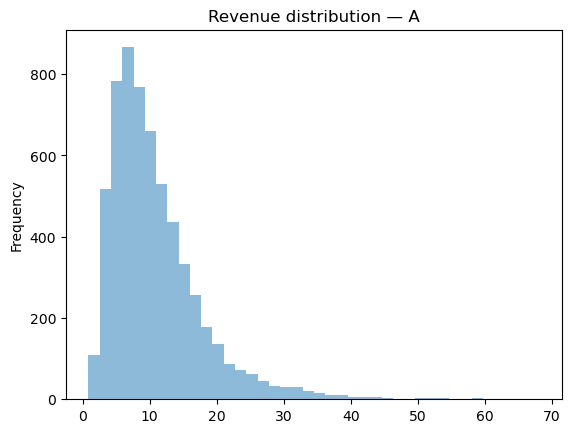

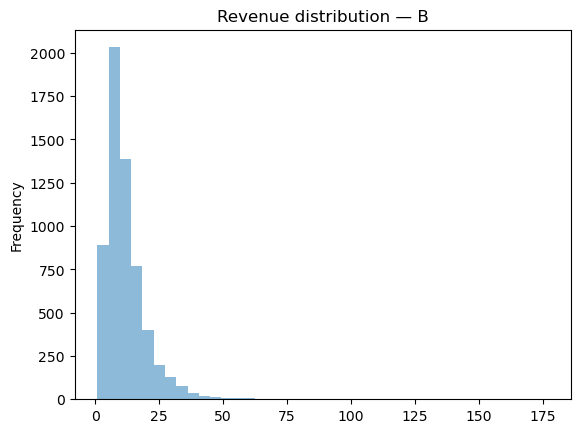

In [54]:
plt.figure()
df[df.variant=='A']['revenue'].dropna().plot(kind='hist', bins=40, alpha=0.5)
plt.title('Revenue distribution — A')
plt.show()

plt.figure()
df[df.variant=='B']['revenue'].dropna().plot(kind='hist', bins=40, alpha=0.5)
plt.title('Revenue distribution — B')
plt.show()

In [ ]:
cr_a = agg.loc['A','cr']; cr_b = agg.loc['B','cr']
txt = f"""Итог A/B по конверсии:
- A: {cr_a:.2%}  (n={total_a})
- B: {cr_b:.2%}  (n={total_b})
- Разница (B-A): {diff:.2%}  [95% CI: {lo:.2%}; {hi:.2%}]
- Относительный эффект: {rel:.2f}%
- z={z:.3f}, p={p:.4f}

Решение: {'фиксируем победителя B' if p<0.05 and diff>0 else 'статзначимых отличий нет/остаемся на A'}.
Ограничения: множество срезов не корректировалось; проверка внешних факторов (акции/сезонность); убедиться в корректности трекинга.
Следующий шаг: протестировать ближайший элемент (оффер/форму/заголовок), рассмотреть CUPED/стратификацию заранее.
"""
print(txt)


Итог A/B по конверсии:
- A: 6.25%  (n=6029)
- B: 6.82%  (n=5971)
- Разница (B-A): 0.56%  [95% CI: -0.32%; 1.45%]
- Относительный эффект: 9.01%
- z=1.248, p=0.2119

Решение: статзначимых отличий нет/остаемся на A.
Ограничения: множество срезов не корректировалось; проверь внешние факторы (акции/сезонность); убедись в корректности трекинга.
Следующий шаг: протестировать ближайший элемент (оффер/форму/заголовок), рассмотреть CUPED/стратификацию заранее.

